In [5]:
import numpy as np
import matplotlib.pyplot as plt
from multi_outputGP import multi_outputGP

ModuleNotFoundError: No module named 'multi_outputGP'

In [44]:
# Attributes
d = 6
m = 2

# Attributes
def f(X):
    fX = np.zeros((X.shape[0], m))
    for j in range(m):
        fX[ :,j] += np.square(1 - X[:, j])
        for i in range(d):
            if i != j:
                fX[ :, j] += np.square(X[:, i])
    return -fX

In [139]:
# Utility function
def true_utility_func(y, parameter):
    return np.dot(parameter, y)

def Linear_utility_func(y, parameter):
    #( Ntheta , Ny , Nm)
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    utility = np.sum(y*parameter,axis=-1)
    return utility

def Tchevicheff_utility_func(y, parameter):
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    scaled_vectors = np.abs(parameter * y)
    utility = np.max(scaled_vectors, axis=-1)
    return -utility

def composed_utility_functions(y, u_funcs, weights, parameters):
    y = np.atleast_2d(y)
    weights = np.atleast_2d(weights)
    parameters = np.atleast_2d(parameters)

    y = y[np.newaxis, :,:]
    parameters_partitioned = np.split(parameters, len(u_funcs), axis=1)
    utility_vals = []
    for p in range(len(parameters_partitioned)):
        params = parameters_partitioned[p][:,np.newaxis, :]
        
        if len(weights[:,p].shape)==1:
            w = weights[:,p][:, np.newaxis]
        
        weighted_utility = u_funcs[p](y, params) * w
        utility_vals.append(weighted_utility)
        
    utility = np.sum(utility_vals,axis=0)
    return utility


def prior_sample_generator(d, n_samples=1, seed=None):
    if seed is None:
        samples = np.random.dirichlet(np.ones((d, )), n_samples)
    else:
        random_state = np.random.RandomState(seed)
        samples = random_state.dirichlet(np.ones((d, )), n_samples)
    return samples

In [147]:
n_samples = 5
u_funcs = [Linear_utility_func, Tchevicheff_utility_func]

In [148]:
initial_n_samples = 10000
X = np.random.random((initial_n_samples, d))
y_data = f(X)



In [155]:
utility_vals = composed_utility_functions(y=y_data, u_funcs=u_funcs, weights=weights, parameters = parameters)
        

(5, 10000)

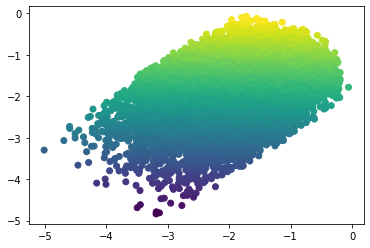

In [154]:
plt.scatter(y_data[:,0],y_data[:,1] ,c =np.array(utility_vals[3]).reshape(-1))

In [ ]:
class Inference_method():
    def __init__(self, u_funcs, d):
        n_ufuncs = len(u_funcs)
        self.m = d
        
    def prior_samples(self, n_samples = 10):
        weights = prior_sample_generator(d=len(u_funcs),n_samples=n_samples)
        Theta = prior_sample_generator(d = self.m , n_samples=n_samples)
        return weights, Theta
    
    def Likelihood_sample(self, n_samples, Pareto_front, preferred_points):
        assert len(Pareto_front) == len(preferred_points); "data does not coincide"
        
        w, t = self.prior_samples(n_samples=n_samples)
        for k in range(len(Pareto_front)):
            utility_vals = composed_utility_functions(y=Pareto_front[k], u_funcs=u_funcs, weights=weights, parameters = parameters)
            pidx = Pareto_front[k] == preferred_points[k]